# Call Pricing under the Black Scholes Model

Author: Jose Melo

## Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import norm
from optimizer import *
from nets import *
from matplotlib import cm
import json
import time
import matplotlib.colors as mcolors
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import axes_grid

%matplotlib widget

DTYPE = torch.float64
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(DTYPE)

## Parameters

In [ ]:
STRIKE = 100
S_MIN, S_MAX =  0, 4*STRIKE
X_MIN, X_MAX = np.log((S_MIN+1e-4)/STRIKE), np.log(S_MAX/STRIKE)   

T     = 1.0      # years to expiry
r     = 0.03     # risk-free (flat)
q     = 0.00     # dividend yield
SIGMA = 0.20     # volatility

In [ ]:
def sample_domain(n_int=25_000, n_bdry=25_000, n_pay=25_000):
    # interior ----------------------------------------------------
    inter       = np.random.rand(n_int, 2)
    inter[:, 0] = inter[:, 0] * T                       
    inter[:, 1] = inter[:, 1]*(X_MAX-X_MIN) + X_MIN 

    # bottom boundary  x = X_MIN ------------------------------
    bot         = np.random.rand(n_bdry, 2)
    bot[:, 0]   = bot[:, 0] * T
    bot[:, 1]   = X_MIN

    # top boundary  x = X_MAX -------------------------------
    top         = np.random.rand(n_bdry, 2)
    top[:, 0]   = top[:, 0] * T
    top[:, 1]   = X_MAX

    # terminal condition  tau = 0 ------------------------------
    pay         = np.random.rand(n_pay, 2)
    pay[:, 0]   = 0.0
    pay[:, 1]   = pay[:, 1]*(X_MAX-X_MIN) + X_MIN

    X = np.vstack([inter, bot, top, pay])
    return torch.tensor(X, dtype=DTYPE, device=DEV)

In [ ]:
def pde_residual(model, X):    
    X.requires_grad_(True)
    V      = model(X)
    grads  = torch.autograd.grad(V.sum(), X, create_graph=True)[0]
    V_tau, V_x  = grads[:, 0], grads[:, 1]
    V_xx        = torch.autograd.grad(V_x.sum(), X, create_graph=True)[0][:, 1]
    return V_tau - 0.5 * SIGMA**2 * (V_xx - V_x) - r * V_x + r * V

def pde_loss(model, X):        
    pde = pde_residual(model, X)    
    return pde.pow(2).mean()

def loss_fn(model, X):
    tau, x = X.t()
    interior = (tau > 0) & (tau < T) & (x > X_MIN) & (x < X_MAX)
    bot     = x == X_MIN
    top     = x == X_MAX
    payoff  = tau == 0

    # interior
    l_int = pde_loss(model, X[interior])

    X_bot = X[bot].requires_grad_(True)
    V_bot = model(X_bot)
    Vtau_bot = torch.autograd.grad(V_bot.sum(), X_bot, create_graph=True)[0][:, 0]
    l_bot = (-Vtau_bot - r * V_bot).pow(2).mean()

    X_top = X[top].requires_grad_(True)
    V_top = model(X_top)
    Vx_top = torch.autograd.grad(V_top.sum(), X_top, create_graph=True)[0][:, 1]
    Vxx_top = torch.autograd.grad(Vx_top.sum(), X_top, create_graph=True)[0][:, 1]
    l_top = (Vxx_top - Vx_top).pow(2).mean()

    # payoff
    x_pay = x[payoff]
    payoff_val = torch.maximum(torch.exp(x_pay)-1.0, torch.zeros_like(x_pay))
    l_pay = (model(X[payoff]) - payoff_val).pow(2).mean()

    print("loss int {:8.2e}  bot {:8.2e}  top {:8.2e}  pay {:8.2e}".format(l_int.item(), l_bot.item(), l_top.item(), l_pay.item()))
    return l_int, l_bot, l_top, l_pay

## Training

In [ ]:
X = sample_domain()

In [ ]:
model = MLP(in_dim=2, hidden_layers=[20, 20], out_dim=1).to(DEV)
for p in model.parameters():
    if p.dim()>1: nn.init.xavier_uniform_(p)

In [ ]:
opt = SSBroyden(model.parameters(), max_iter=20_000, tolerance_change=1e-10, tolerance_grad=1e-10)

benchmark = {'Interior': [], 'Bottom': [], 'Top': [], 'Payoff': [], 'Total': [], 'time': 0.0}
def closure(*args, **kwargs):
    opt.zero_grad()
    l_int, l_bot, l_top, l_pay = loss_fn(model, X)
    loss = l_int + l_bot + l_top + l_pay
    benchmark["Interior"].append(l_int.item())
    benchmark["Bottom"].append(l_bot.item())
    benchmark["Top"].append(l_top.item())
    benchmark["Payoff"].append(l_pay.item())
    benchmark["Total"].append(loss.item())  
    loss.backward()    
    return loss

start = time.time()
opt.step(closure)
end = time.time()
benchmark["time"] = end - start
print("training finished")

In [ ]:
with open("call.json", "w") as f:
    json.dump(benchmark, f, indent=4)
torch.save(model.state_dict(), "call.pt")

In [ ]:
model.load_state_dict(torch.load("call.pt", map_location=DEV))
benchmark = json.load(open("call.json"))

In [ ]:
model.eval()
with torch.no_grad():
    tau = torch.linspace(0, T, 100, device=DEV)
    x = torch.linspace(X_MIN, X_MAX, 100, device=DEV)
    t = (1-tau)*T
    s = STRIKE * torch.exp(x)
    tau, x = torch.meshgrid(tau, x, indexing="ij")

    x = torch.stack([tau.reshape(-1), x.reshape(-1)], dim=1)
    u = model(x).reshape(tau.shape)
    v_pinn = u*STRIKE


### Loss Evolution

In [ ]:
plt.figure(figsize=(10, 4))
for k,v in benchmark.items():
    if k != "time":
        plt.plot(v, label=k)
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.yscale('log')
plt.title("Loss Evolution")
plt.legend()
plt.grid()
plt.show()

### Exact Solution

In [ ]:
with torch.no_grad():
    n_t, n_x = 100, 100
    tau_vec  = torch.linspace(0.0, T, n_t, device=DEV)           # tau = T − t
    x_vec  = torch.linspace(X_MIN, X_MAX, n_x, device=DEV)
    tau_t, x_t = torch.meshgrid(tau_vec, x_vec, indexing="ij")

    X_grid = torch.stack([tau_t.reshape(-1), x_t.reshape(-1)], dim=1)
    V_pinn = model(X_grid).reshape(tau_t.shape) * STRIKE         # (torch)

tau_np   = tau_t.cpu().numpy()
x_np   = x_t.cpu().numpy()
S_np   = STRIKE * np.exp(x_np)

sqrttau  = np.sqrt(np.maximum(tau_np, 1e-12))
d1 = (np.log(S_np / STRIKE) + (r - q + 0.5*SIGMA**2) * tau_np) / (SIGMA * sqrttau)
d2 = d1 - SIGMA * sqrttau
V_bs_np = (S_np * np.exp(-q * tau_np) * norm.cdf(d1) - STRIKE * np.exp(-r * tau_np) * norm.cdf(d2))

V_pinn_np = V_pinn.cpu().numpy()
err_np    = np.abs(V_pinn_np - V_bs_np)

t_np = T - tau_np   

In [ ]:
fig = plt.figure(figsize=(14, 6))

# (1) PINN surface
surf_kw = dict(rstride=1, cstride=1, antialiased=False,
               linewidth=0, shade=True)     # no grid lines


ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(t_np, S_np, V_pinn_np, cmap=cm.viridis, **surf_kw)
ax1.set_title('PINN Solution')
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Stock price $S$')
ax1.set_zlabel('Value')

# (2) Black–Scholes surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(t_np, S_np, V_bs_np,   cmap=cm.plasma,  **surf_kw)

ax2.set_title('Exact Solution')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Stock price $S$')
ax2.set_zlabel('Value')

fig.tight_layout()
plt.show()

In [ ]:
# smooth absolute / relative-error heat-maps
fig2 = plt.figure(figsize=(10, 7))

eps = 1e-4
rel_err_np = np.abs(V_pinn_np - V_bs_np) / np.where(np.abs(V_bs_np) > eps,
                                                    V_bs_np,
                                                    np.nan)

# absolute error -----------------------------------------------------------
ax1 = fig2.add_subplot(2, 1, 1)
cmesh1 = ax1.pcolormesh(S_np, t_np, err_np,
                        shading="gouraud",           # <- smooth shading
                        cmap="inferno")
ax1.set_title("Absolute error |V_PINN - V_BS|")
ax1.set_xlabel("Stock price S")
ax1.set_ylabel("Time t")
ax1.axvline(x=STRIKE, color="red", linestyle="--", linewidth=2,
            label="Strike = {}".format(STRIKE))
ax1.legend()
fig2.colorbar(cmesh1, ax=ax1, label="Absolute error")

# relative error -----------------------------------------------------------
ax2 = fig2.add_subplot(2, 1, 2)
log_norm = mcolors.LogNorm(vmin=np.nanmin(rel_err_np[rel_err_np > 0]),
                           vmax=np.nanmax(rel_err_np))
cmesh2 = ax2.pcolormesh(S_np, t_np, rel_err_np,
                        shading="gouraud",           # <- smooth shading
                        cmap="viridis",
                        norm=log_norm)
ax2.set_title("Relative error |V_PINN - V_BS| / V_BS")
ax2.set_xlabel("Stock price S")
ax2.set_ylabel("Time t")
ax2.axvline(x=STRIKE, color="red", linestyle="--", linewidth=2,
            label="Strike = {}".format(STRIKE))
ax2.legend()
fig2.colorbar(cmesh2, ax=ax2, label="Relative error")

fig2.tight_layout()
plt.show()

In [ ]:
np.linalg.norm(err_np, ord=2) / np.linalg.norm(V_bs_np, ord=2)  

In [ ]:
# --- relative error ---------------------------------------------------------
# Avoid division by zero: wherever V_bs_np == 0 put NaN (or a small epsilon)
eps = 1e-4                 # pick something ≪ typical option value
den  = np.maximum(np.abs(V_bs_np), eps)
rel_err_np  = np.abs(V_pinn_np - V_bs_np) / den
rel_err_pct = 100 * rel_err_np


# --- plot -------------------------------------------------------------------
fig3 = plt.figure(figsize=(7, 5))
ax3  = fig3.add_subplot(111)

# A log-colour scale makes the small errors visible
log_norm = mcolors.LogNorm(vmin=np.nanmin(rel_err_np[rel_err_np>0]),
                           vmax=np.nanmax(rel_err_np))

cmesh = ax3.pcolormesh(S_np, t_np, rel_err_np,
                       shading='auto',
                       cmap='viridis',
                       norm=log_norm)         # <- log scale

ax3.set_title(r'Relative error $|(V_{\mathrm{PINN}}-V_{\mathrm{BS}})| / V_{\mathrm{BS}}$')
ax3.set_xlabel('Stock price $S$')
ax3.set_ylabel('Time $t$')

cb = fig3.colorbar(cmesh, ax=ax3, label='Relative error')
cb.update_ticks()

fig3.tight_layout()
plt.show()


In [ ]:

# 1) build a non-uniform price grid
delta     = 12.0    # half-width of the dense region [K-delta , K+delta]
n_dense   = 800     # points inside the dense band
n_left    = 100     # points to the left  of the band
n_right   = 100     # points to the right of the band

S_left  = np.linspace(S_MIN,           STRIKE - delta, n_left,  endpoint=False)
S_mid   = np.linspace(STRIKE - delta,  STRIKE + delta, n_dense, endpoint=False)
S_right = np.linspace(STRIKE + delta,  S_MAX,          n_right)
S_grid  = np.concatenate([S_left, S_mid, S_right])           # 1-D array

# 2) evaluate the PINN on tau = 0 for these prices
with torch.no_grad():
    tau0  = torch.zeros_like(torch.tensor(S_grid, dtype=DTYPE, device=DEV))
    x_val = torch.log(torch.tensor(S_grid, dtype=DTYPE, device=DEV) / STRIKE)
    X_in  = torch.stack([tau0, x_val], dim=1)                 # shape (N,2)
    V_pinn_exp = (model(X_in) * STRIKE).cpu().numpy().flatten()

# 3) exact payoff
payoff_exact = np.maximum(S_grid - STRIKE, 0.0)

# 4) main figure
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(S_grid, payoff_exact, lw=2.0, color="red", label="Exact payoff")
ax.plot(S_grid, V_pinn_exp,  lw=1.6, color="blue", label="PINN (T=1)")
ax.set_xlabel("Stock price S")
ax.set_ylabel("Value at expiry")
ax.set_title("PINN value at expiry vs exact payoff")
ax.grid(alpha=0.3)
ax.legend()

# 6) inset zoom of the dense band
ax_ins = inset_axes(ax, width="42%", height="42%", loc="right", borderpad=2)
ax_ins.plot(S_grid, payoff_exact, lw=2.0, color="red")
ax_ins.plot(S_grid, V_pinn_exp,  lw=1.6, color="blue")
x0, x1 = STRIKE - delta, STRIKE + delta
mask   = (S_grid >= x0) & (S_grid <= x1)
y_min  = min(payoff_exact[mask].min(), V_pinn_exp[mask].min())
y_max  = max(payoff_exact[mask].max(), V_pinn_exp[mask].max())
ax_ins.set_xlim(x0, x1)
ax_ins.set_ylim(y_min-1, y_max * 1.05)
ax_ins.set_xticks([x0, STRIKE, x1])
ax_ins.tick_params(labelsize=8)
ax_ins.grid(alpha=0.3)

# draw connectors between inset and circle
mark_inset(ax, ax_ins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()


In [ ]:
# 1) define an extended price range beyond the training limit
S_max_train = S_MAX              # 4*STRIKE (== 400 if STRIKE=100)
S_max_extra = 8.0 * STRIKE       # evaluate up to 8*K  (== 800 here)

n_tau  = 100                     # tau grid resolution
n_x_ex = 100                     # S grid resolution in the extra band

tau_vec = torch.linspace(0.0, T, n_tau, device=DEV)             # tau = T - t
x_ex    = torch.linspace(np.log((S_max_train-100) / STRIKE),
                         np.log(S_max_extra  / STRIKE),
                         n_x_ex, device=DEV)

Tau_ex, X_ex  = torch.meshgrid(tau_vec, x_ex, indexing="ij")     # shape (n_tau,n_x_ex)
X_grid_ex     = torch.stack([Tau_ex.reshape(-1),
                             X_ex.reshape(-1)], dim=1)

# 2) PINN price on the extended grid
with torch.no_grad():
    V_pinn_ex = (model(X_grid_ex) * STRIKE).reshape(n_tau, n_x_ex).cpu().numpy()

# 3) Black–Scholes exact price on the same grid
S_ex_np   = STRIKE * np.exp(X_ex.cpu().numpy())                 # (n_tau,n_x_ex)
tau_ex_np = Tau_ex.cpu().numpy()

sqrt_tau  = np.sqrt(np.maximum(tau_ex_np, 1e-12))
d1_ex = (np.log(S_ex_np / STRIKE) + (r - q + 0.5 * SIGMA**2) * tau_ex_np) / (SIGMA * sqrt_tau)
d2_ex = d1_ex - SIGMA * sqrt_tau
V_bs_ex = (S_ex_np * np.exp(-q * tau_ex_np) * norm.cdf(d1_ex) -
           STRIKE  * np.exp(-r * tau_ex_np) * norm.cdf(d2_ex))

# 4) absolute error
err_ex = np.abs(V_pinn_ex - V_bs_ex)

# 5) plot as a smooth heat-map (Gouraud interpolation)
fig_ex = plt.figure(figsize=(10, 4))
ax_ex  = fig_ex.add_subplot(111)

pcm = ax_ex.pcolormesh(S_ex_np, T - tau_ex_np, err_ex,
                       shading="gouraud",
                       cmap="inferno")
ax_ex.set_title("Absolute error outside training domain")
ax_ex.set_xlabel("Stock price S")
ax_ex.set_ylabel("Time t")

# vertical line marking the training limit
ax_ex.axvline(x=S_max_train, color="red", linestyle="--",
              linewidth=2, label="train S max")
ax_ex.legend()

fig_ex.colorbar(pcm, ax=ax_ex, label="Absolute error")
fig_ex.tight_layout()
plt.show()


Δ_PINN   min=-0.0659  max= 1.0449
Γ_PINN   min=-0.0124  max= 0.1008
Θ_PINN   min=-18.7831  max= 1.8831


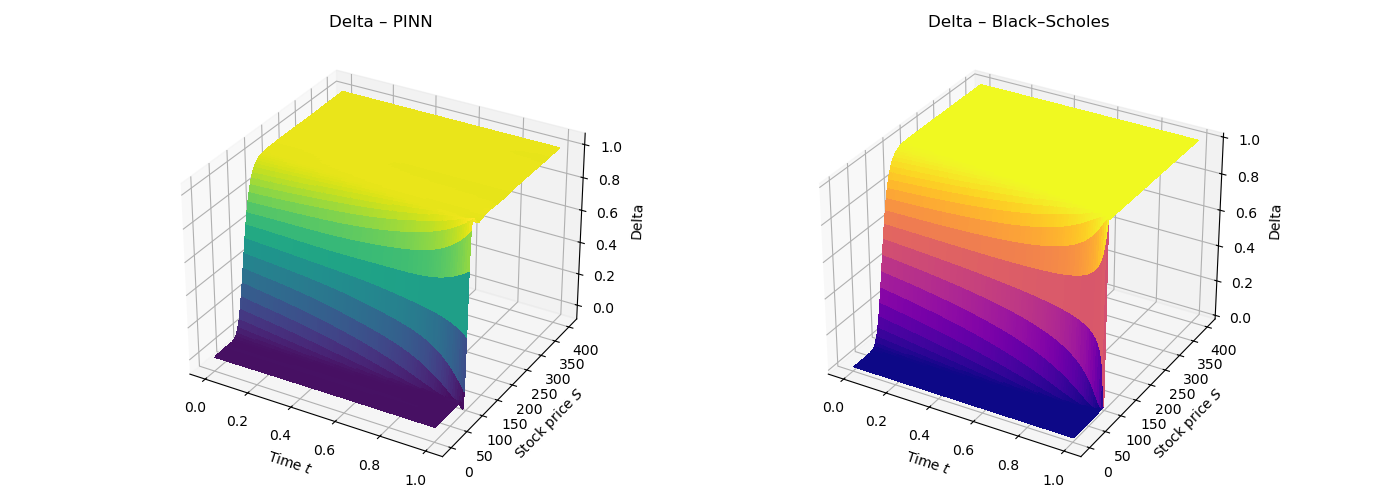

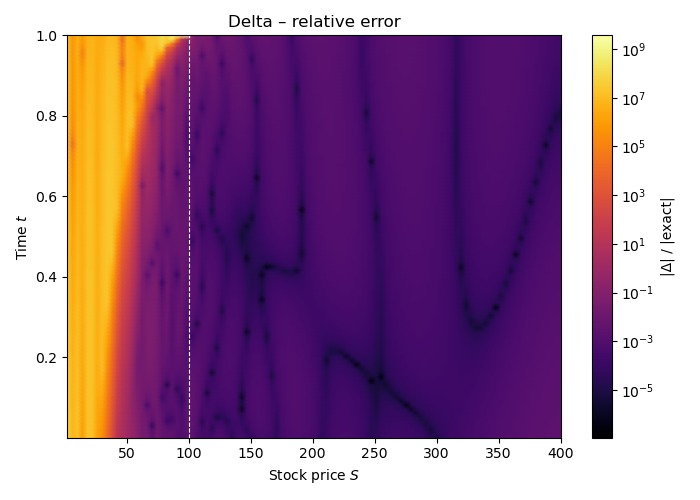

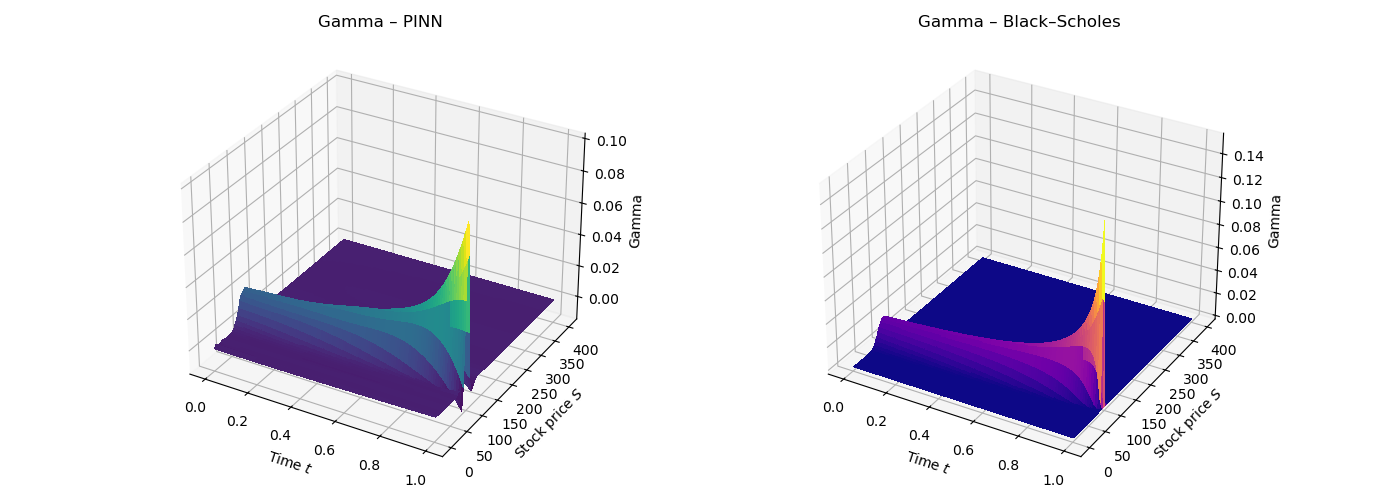

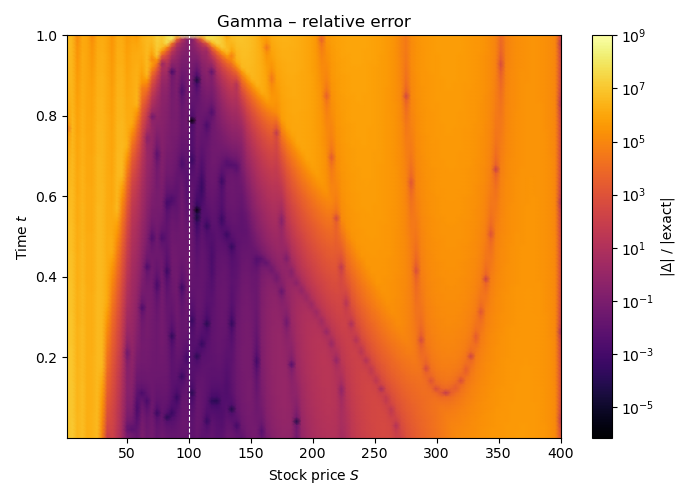

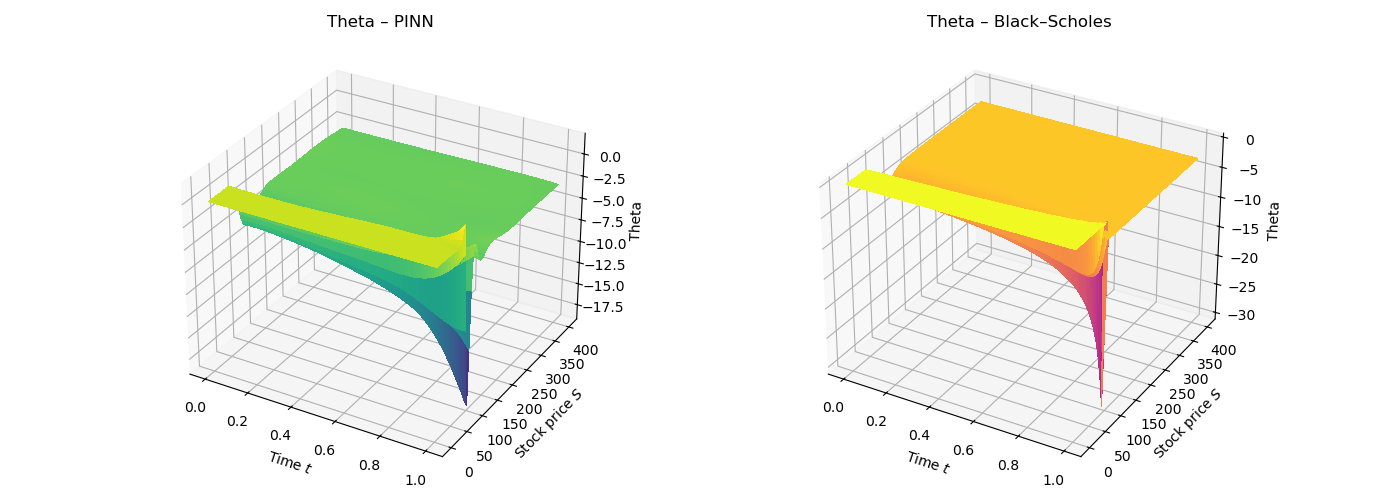

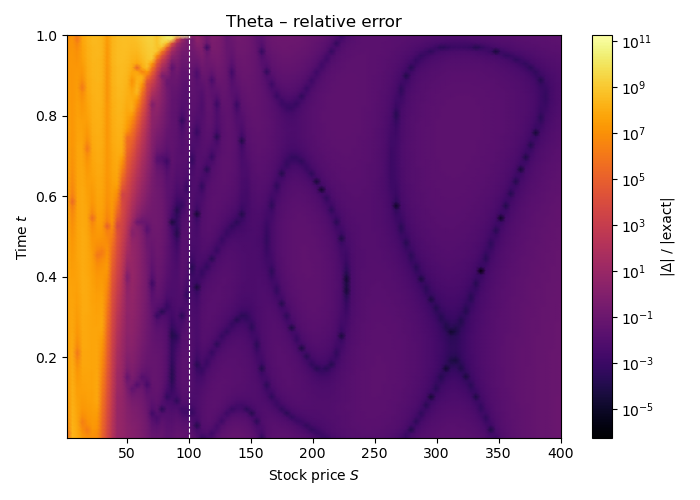

In [67]:
# %% [markdown]
# ### Greeks – consistent evaluation grid (no S = 0)
# %%
import torch, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D        # noqa: F401
from matplotlib import cm, colors as mcolors
from scipy.stats import norm

model.eval()

# ── 0) grid parameters ─────────────────────────────────────────────────────
n_t, n_S = 100, 100         # resolution in τ and S
S_EPS    = 2             # strictly positive lower bound for S

# τ and S vectors
tau_vec = torch.linspace(0.0, T-1e-6, n_t, device=DEV)           # τ = T − t
S_vec   = torch.linspace(S_EPS, S_MAX, n_S, device=DEV)     # S ∈ (S_EPS, S_MAX]

# 2-D mesh (tau × S)  --------------  everything derives from this
tau_t, S_t = torch.meshgrid(tau_vec, S_vec, indexing="ij")   # shape (n_t, n_S)
x_t        = torch.log(S_t / STRIKE)                         # log-moneyness

# flattened input for the PINN
X_flat = torch.stack([tau_t.reshape(-1), x_t.reshape(-1)], dim=1
                    ).to(DEV).requires_grad_(True)

# ── 1) network output and derivatives ──────────────────────────────────────
u = model(X_flat)                                # shape (N,1)

# first derivatives
grads  = torch.autograd.grad(u, X_flat,
                             grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
u_tau, u_x = grads[:, :1], grads[:, 1:]          # keep as (N,1)

# second derivative ∂²u/∂x²
u_xx = torch.autograd.grad(u_x, X_flat,
                           grad_outputs=torch.ones_like(u_x),
                           create_graph=True)[0][:, 1:2]

# reshape back to (n_t, n_S)
shape2d = tau_t.shape
u_tau = u_tau.reshape(shape2d)
u_x   = u_x.reshape(shape2d)
u_xx  = u_xx.reshape(shape2d)

# ── 2) Greeks from the PINN (chain rule) ───────────────────────────────────
S_torch    = S_t                                            # alias
Delta_pinn = (STRIKE / S_torch)    * u_x
Gamma_pinn = (STRIKE / S_torch**2) * (u_xx - u_x)
Theta_pinn = (-STRIKE)              * u_tau                 # calendar Θ

Δ_pin = Delta_pinn.detach().cpu().numpy()
Γ_pin = Gamma_pinn.detach().cpu().numpy()
Θ_pin = Theta_pinn.detach().cpu().numpy()

# ── 3) exact Greeks on the same grid ───────────────────────────────────────
# move τ and S to NumPy
tau_np = tau_t.cpu().numpy()
S_np   = S_t.cpu().numpy()

sqrt_tau = np.sqrt(np.maximum(tau_np, 1e-12))
d1 = (np.log(S_np/STRIKE) + (r - q + 0.5*SIGMA**2)*tau_np) / (SIGMA*sqrt_tau)
d2 = d1 - SIGMA*sqrt_tau
pdf = norm.pdf(d1)

Delta_bs = np.exp(-q*tau_np) * norm.cdf(d1)
Gamma_bs = np.exp(-q*tau_np) * pdf / (S_np*SIGMA*sqrt_tau)
Theta_bs = (- S_np*pdf*SIGMA*np.exp(-q*tau_np)/(2*sqrt_tau)
            - r*STRIKE*np.exp(-r*tau_np)*norm.cdf(d2)
            + q*S_np*np.exp(-q*tau_np)*norm.cdf(d1))

# ── 4) quick diagnostic printout ───────────────────────────────────────────
for n, arr in [('Δ_PINN', Δ_pin), ('Γ_PINN', Γ_pin), ('Θ_PINN', Θ_pin)]:
    print(f'{n:7s}  min={np.nanmin(arr): .4f}  max={np.nanmax(arr): .4f}')

# ── 5) plotting helpers ───────────────────────────────────────────────────
def surface_pair(pin, bs, title, cmap_p=cm.viridis, cmap_b=cm.plasma):
    fig = plt.figure(figsize=(14,5))
    # PINN
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.plot_surface((T - tau_np), S_np, pin, cmap=cmap_p,
                     rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax1.set_title(f'{title} – PINN')
    ax1.set_xlabel('Time $t$'); ax1.set_ylabel('Stock price $S$'); ax1.set_zlabel(title)
    # Black-Scholes
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot_surface((T - tau_np), S_np, bs, cmap=cmap_b,
                     rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax2.set_title(f'{title} – Black–Scholes')
    ax2.set_xlabel('Time $t$'); ax2.set_ylabel('Stock price $S$'); ax2.set_zlabel(title)
    plt.tight_layout(); plt.show()

def rel_err(pin, bs, title):
    eps = 1e-10
    rel = np.abs(pin - bs) / np.maximum(np.abs(bs), eps)
    fig, ax = plt.subplots(figsize=(7,5))
    norm = mcolors.LogNorm(vmin=rel[rel>0].min(), vmax=rel.max())
    pcm  = ax.pcolormesh(S_np, (T - tau_np), rel,
                         shading='gouraud', cmap='inferno', norm=norm)
    ax.set_title(f'{title} – relative error')
    ax.set_xlabel('Stock price $S$'); ax.set_ylabel('Time $t$')
    ax.axvline(STRIKE, ls='--', lw=0.8, color='white')
    fig.colorbar(pcm, ax=ax, label='|Δ| / |exact|')
    plt.tight_layout(); plt.show()

# ── 6) draw Δ, Γ, Θ ────────────────────────────────────────────────────────
surface_pair(Δ_pin, Delta_bs, 'Delta');  rel_err(Δ_pin, Delta_bs, 'Delta')
surface_pair(Γ_pin, Gamma_bs, 'Gamma');  rel_err(Γ_pin, Gamma_bs, 'Gamma')
surface_pair(Θ_pin, Theta_bs, 'Theta');  rel_err(Θ_pin, Theta_bs, 'Theta')
